<a href="https://colab.research.google.com/github/ashwathyashokan97/academic-projects/blob/Dev/Algerian_Forest_Fire_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Import Required Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [43]:
from google.colab import files
uploaded = files.upload()

Saving Algerian_forest_fires_cleaned.csv to Algerian_forest_fires_cleaned (2).csv


## Step 2: Load and Explore Dataset

In [44]:
df = pd.read_csv("Algerian_forest_fires_cleaned.csv")
print(df.head())
df.info()
df.describe()

   day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           29  57  18   0.0  65.7  3.4   7.6  1.3  3.4   
1    2      6  2012           29  61  13   1.3  64.4  4.1   7.6  1.0  3.9   
2    3      6  2012           26  82  22  13.1  47.1  2.5   7.1  0.3  2.7   
3    4      6  2012           25  89  13   2.5  28.6  1.3   6.9  0.0  1.7   
4    5      6  2012           27  77  16   0.0  64.8  3.0  14.2  1.2  3.9   

   FWI      Classes  Region  
0  0.5  not fire          0  
1  0.4  not fire          0  
2  0.1  not fire          0  
3  0.0  not fire          0  
4  0.5  not fire          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Region
count,243.000000,243.000000,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,15.761317,7.502058,2012.0,32.152263,62.041152,15.493827,0.762963,77.842387,14.680658,49.430864,4.742387,16.690535,7.035391,0.497942
std,8.842552,1.114793,0.0,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,47.665606,4.154234,14.228421,7.440568,0.501028
min,1.000000,6.000000,2012.0,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000,0.000000
25%,8.000000,7.000000,2012.0,30.000000,52.500000,14.000000,0.000000,71.850000,5.800000,12.350000,1.400000,6.000000,0.700000,0.000000
50%,16.000000,8.000000,2012.0,32.000000,63.000000,15.000000,0.000000,83.300000,11.300000,33.100000,3.500000,12.400000,4.200000,0.000000
75%,23.000000,8.000000,2012.0,35.000000,73.500000,17.000000,0.500000,88.300000,20.800000,69.100000,7.250000,22.650000,11.450000,1.000000
max,31.000000,9.000000,2012.0,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000,1.000000


Step 3: Data cleaning and preprocessing

In [45]:
# Define proper column names manually (based on the dataset structure)
column_names = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain',
                'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region']

# Load the dataset with no header row in CSV
df_raw = pd.read_csv("Algerian_forest_fires_cleaned.csv", header=None, names=column_names)

# Drop repeated headers (in case regions were merged with headers in between)
df_raw = df_raw[df_raw['Temperature'] != 'Temperature']  # remove header duplicates

# Convert all numeric columns
for col in df_raw.columns:
    if col not in ['Classes', 'Region']:
        try:
            df_raw[col] = pd.to_numeric(df_raw[col])
        except:
            pass

# Create a datetime column from day/month/year
df_raw['Date'] = pd.to_datetime(df_raw[['day', 'month', 'year']])

# Drop original day/month/year
df_raw.drop(['day', 'month', 'year'], axis=1, inplace=True)

# Drop Region column if not needed
df_raw.drop(['Region'], axis=1, inplace=True)

# Drop rows with missing values
df_raw.dropna(inplace=True)

# Reset index
df_raw.reset_index(drop=True, inplace=True)

# Preview
df_raw.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Date
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,2012-06-01
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,2012-06-02
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,2012-06-03
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,2012-06-04
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,2012-06-05


In [46]:
df_raw['Classes'] = df_raw['Classes'].map({'not_fire': 0, 'fire': 1})
df_raw['Classes'].value_counts()

,count
Classes,
1.0,4


Step4: Exploratory data analysis and Visualization

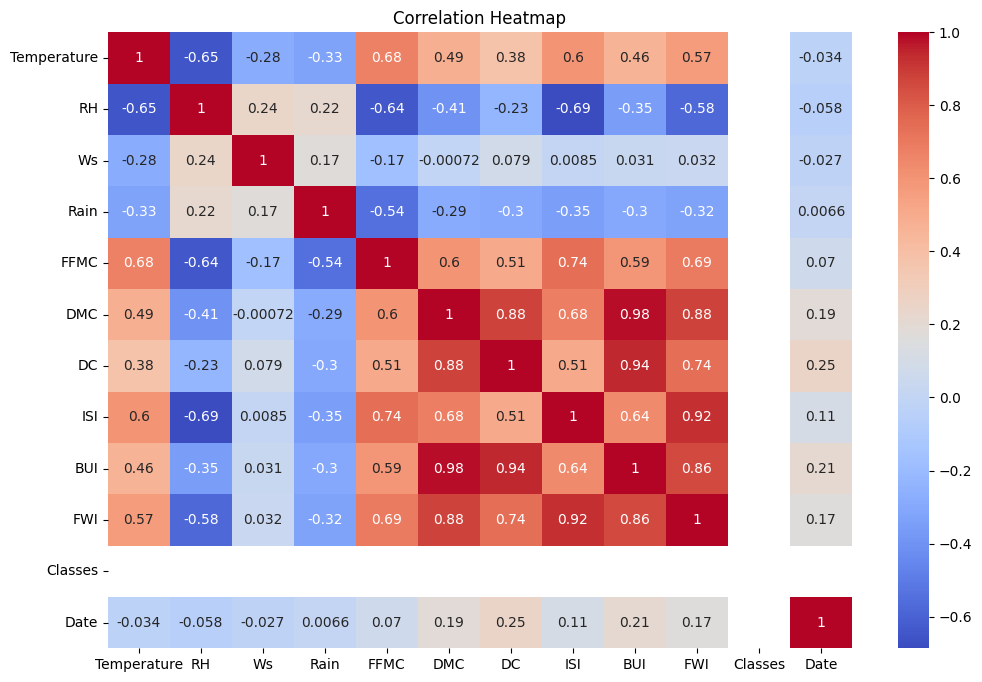

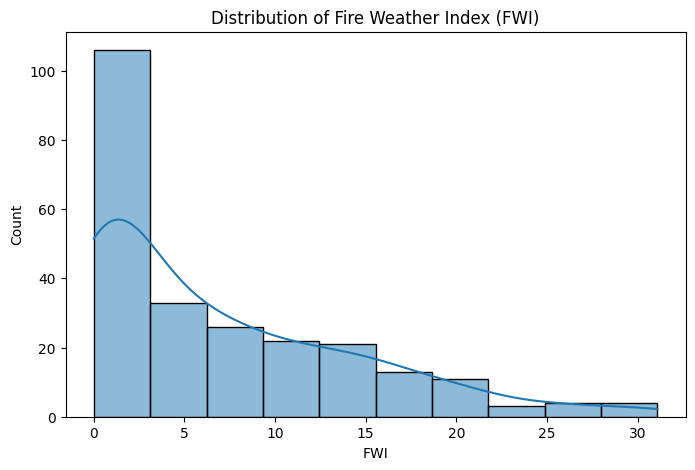

In [38]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_raw['FWI'], kde=True)
plt.title("Distribution of Fire Weather Index (FWI)")
plt.show()


Step5: Feature Scaling

In [47]:
# Define features and target
X = df_raw.drop('FWI', axis=1)
y = df_raw['FWI']

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Step6: Train-Test Split

In [48]:
if 'Date' in X_train.columns:
    X_train = X_train.drop('Date', axis=1)
if 'Date' in X_test.columns:
    X_test = X_test.drop('Date', axis=1)

Step 7: Linear Regression Model Development

In [49]:
# Initialize the imputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit imputer on training data and transform both training and test sets
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

Step 8: Regularization using Ridge and Lasso

In [50]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Step 9: Model Evaluation and Cross-Validation

In [51]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

Lasso()

Step 10: Saving and Loading the Model to Pickle

In [52]:
# Save the trained model to a file
with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

Step 11: Summary of Results

In [53]:
# Load the model from the file
with open('linear_regression_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Use the loaded model to predict
y_pred = loaded_model.predict(X_test_scaled)

In [54]:
# Predict using each model
y_pred_lr = lr.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)

# Print metrics
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))

print("\nRidge Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R2:", r2_score(y_test, y_pred_ridge))

print("\nLasso Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R2:", r2_score(y_test, y_pred_lasso))

Linear Regression:
MSE: 0.35543638257764865
R2: 0.9882726857720828

Ridge Regression:
MSE: 0.5645231898376829
R2: 0.9813740484635773

Lasso Regression:
MSE: 1.4308089977464673
R2: 0.9527917018651335


Analysis has been uploaded in github - repository link : https://github.com/ashwathyashokan97/academic-projects/tree/Dev